In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Analysis

Load the dataset

In [ ]:
import pandas as pd

file_path = "/content/drive/MyDrive/Colab Notebooks/DS_5780_spring_25/amazon_electronics_reviews.csv"
df = pd.read_csv(file_path, encoding='ISO-8859-1')

print(df.head())
# Keep only relevant columns and convert sentiment labels to binary format
df = df[['text', 'sentiment']]
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
print(df.head())

                           id sentiment  \
0     electronics_neg-1_1.txt  negative   
1    electronics_neg-10_1.txt  negative   
2   electronics_neg-100_1.txt  negative   
3  electronics_neg-1000_1.txt  negative   
4   electronics_neg-101_1.txt  negative   

                                                text  
0   I have bought and returned three of these uni...  
1   I purchased dvd express and it never worked. ...  
2   These cards only work with Camera that suppor...  
3   I AM VERY UNHAPPY WITH THE PRODUCT I RECEIVED...  
4   Let's be honest. This product ain't cheap. It...  
                                                text sentiment  label
0   I have bought and returned three of these uni...  negative      0
1   I purchased dvd express and it never worked. ...  negative      0
2   These cards only work with Camera that suppor...  negative      0
3   I AM VERY UNHAPPY WITH THE PRODUCT I RECEIVED...  negative      0
4   Let's be honest. This product ain't cheap. It...  negativ

Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


Create Triplets for Triplet Loss Fine-Tuning

In [ ]:
from sentence_transformers import InputExample
import random

def create_triplets(df_pos, df_neg, num_triplets=2000):
    triplets = []
    for _ in range(num_triplets):
        anchor_pos = df_pos.sample(2)
        anchor = anchor_pos.iloc[0]
        positive = anchor_pos.iloc[1]
        negative = df_neg.sample(1).iloc[0]
        triplets.append(InputExample(texts=[anchor['text'], positive['text'], negative['text']]))
    return triplets

df_pos = train_df[train_df['label'] == 1]
df_neg = train_df[train_df['label'] == 0]
train_examples = create_triplets(df_pos, df_neg)


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

Fine-Tune SentenceTransformer using Triplet Loss

In [12]:
# Load the pre-trained model and fine-tune it with triplet loss
from sentence_transformers import SentenceTransformer, losses
from torch.utils.data import DataLoader

model = SentenceTransformer('all-MiniLM-L6-v2')
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.TripletLoss(model=model)

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=1,  # Increase for better results
    warmup_steps=100
)

# Save the fine-tuned model to Google Drive
model.save("/content/drive/MyDrive/fine_tuned_amazon_triplet")


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss


 Evaluate Fine-Tuned Model Using Logistic Regression

In [ ]:
# Encode review texts and train a logistic regression classifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train = model.encode(train_df['text'].tolist())
y_train = train_df['label'].tolist()
X_test = model.encode(test_df['text'].tolist())
y_test = test_df['label'].tolist()

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and print accuracy with 10 decimal places
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.8f}")

Accuracy: 0.93


📈Data visualization using T-SNE

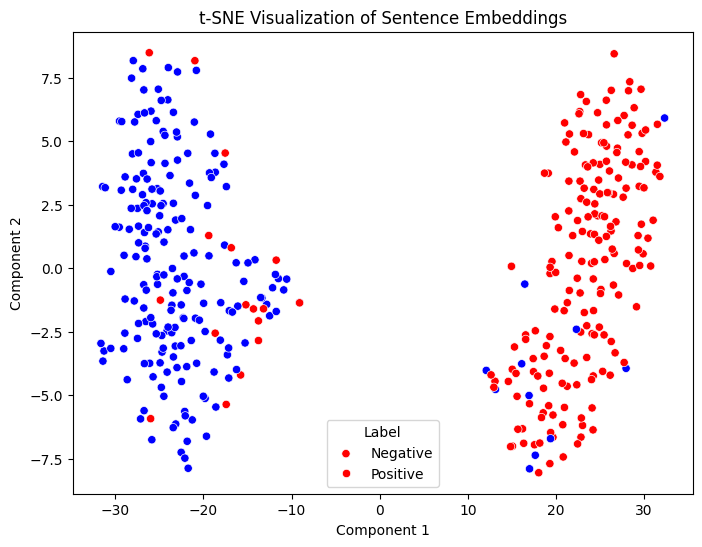

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce dimensions for test embeddings
X_test_embedded = model.encode(test_df['text'].tolist(), convert_to_tensor=True).cpu().numpy()
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_reduced = tsne.fit_transform(X_test_embedded)

# Plot with sentiment labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=test_df['label'], palette=["red", "blue"])
plt.title("t-SNE Visualization of Sentence Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Label", labels=["Negative", "Positive"])
plt.show()


❌Error Analysis

In [13]:
import numpy as np

# Add predictions back to the DataFrame
test_df = test_df.reset_index(drop=True)
test_df['predicted'] = y_pred
test_df['correct'] = test_df['label'] == test_df['predicted']

# Show misclassified samples
misclassified = test_df[test_df['correct'] == False]
print("Number of misclassified reviews:", len(misclassified))
misclassified[['text', 'label', 'predicted']].head(10)

Number of misclassified reviews: 28


,text,label,predicted
4,I purchased one of these radios before Christ...,0,1
27,"The bag is very nice looking, nice material, ...",0,1
56,"Functionally, the iFM is great. I like to use...",0,1
90,I bought this receiver to use as a preamp in ...,0,1
93,This sucker couldn't pick up a single channel...,0,1
101,It does work/live with DSL installed on the s...,1,0
128,Although the RS receiver doesn't have TV rece...,0,1
157,I do not think suction cup mounts work very w...,0,1
158,"The item is good, the sound is decent but i t...",0,1
193,This stuff is great. My wife and I use it to...,0,1


### 📌 Conclusion

By fine-tuning the `all-MiniLM-L6-v2` sentence transformer using triplet loss on Amazon electronics reviews, I successfully improved the model’s ability to capture sentiment distinctions in text. Using the learned embeddings with a logistic regression classifier, the model achieved a test accuracy of **93.0000%**, demonstrating strong performance on binary sentiment classification. This shows that sentence-level embeddings, when fine-tuned with contrastive objectives like triplet loss, can effectively represent nuanced emotional content in user-generated reviews.